In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import json
import numpy as np
import pandas as pd
import random
from matplotlib import pyplot as plt
import seaborn as sns
from wordcloud import WordCloud,STOPWORDS
import missingno as msno

In [3]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

from keras.preprocessing import text
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout
from keras.callbacks import ReduceLROnPlateau

In [4]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import nltk
from nltk import word_tokenize
from nltk.stem import PorterStemmer

import torch
from torch.utils.data import Dataset

In [5]:
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from transformers import pipeline
from transformers import DistilBertTokenizerFast
from transformers import BertForSequenceClassification, BertTokenizerFast
from transformers import TFDistilBertForSequenceClassification, TFTrainer, TFTrainingArguments
from transformers import BertTokenizer, TFBertForSequenceClassification, BertConfig
from transformers import TrainingArguments, Trainer

In [6]:
def load_json_file(filename):
    with open(filename, 'r', encoding='utf-8') as f:
        file = json.load(f)
    return file

filename = r'C:\Users\lenovo\Documents\Coding Jupyter\intentsFTMM.json'

intents = load_json_file(filename)

In [57]:
def buat_dataframe():
    df = pd.DataFrame({
        'Pattern' : [],
        'Tag' : []
    })
    
    return df

df = buat_dataframe()
df

,Pattern,Tag


In [58]:
def ambil_json(json_file, df):
    
    for intent in json_file['intents']:
        
        for pattern in intent['patterns']:
            
            sentence_tag = [pattern, intent['tag']]
            df.loc[len(df.index)] = sentence_tag
                
    return df

df = ambil_json(intents, df)
df

,Pattern,Tag
0,Halo,Pengenalan
1,Hai,Pengenalan
2,selamat pagi,Pengenalan
3,selamat siang,Pengenalan
4,selamat malam,Pengenalan
...,...,...
106,Kelompok riset renewable and Sustainable Energ...,Bidang R & SE Technology
107,Apa itu Intelligent Power and Control Engineer...,IE & C Engineering
108,Kelompok Intelligent Power and Control Enginee...,Bidang IE & C Engineering
109,Apa saja fasilitas yang ada pada kelompok Inte...,Fasilitas IE & C Engineering


In [9]:
df2 = df.copy()
df2.head()

,Pattern,Tag
0,Halo,Pengenalan
1,Hai,Pengenalan
2,selamat pagi,Pengenalan
3,selamat siang,Pengenalan
4,selamat malam,Pengenalan


In [59]:
def cek_shape_df(df, ds_name="df"):
    print(f"{ds_name} dataset has {df.shape[0]} rows and {df.shape[1]} columns")
    
cek_shape_df(df, "Chatbot")

Chatbot dataset has 111 rows and 2 columns


In [60]:
def cek_info_df(df, ds_name="df"):
    print(f"The info of {ds_name} dataset\n")
    print(df.info())
    
cek_info_df(df, "Chatbot")

The info of Chatbot dataset

<class 'pandas.core.frame.DataFrame'>
Index: 111 entries, 0 to 110
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Pattern  111 non-null    object
 1   Tag      111 non-null    object
dtypes: object(2)
memory usage: 2.6+ KB
None


In [61]:
def cek_total_kelas(df, target_col, ds_name="df"):
    print(f"The {ds_name} dataset has {len(df[target_col].unique())} classes")
    
cek_total_kelas(df, 'Tag', "Chatbot")

The Chatbot dataset has 62 classes


In [62]:
def cek_nilai_null(df, ds_name='df'):
    print(f"Null Values in each col in the {ds_name} dataset:\n")
    print(df.isnull().sum())
    
cek_nilai_null(df, "Chatbot")

Null Values in each col in the Chatbot dataset:

Pattern    0
Tag        0
dtype: int64


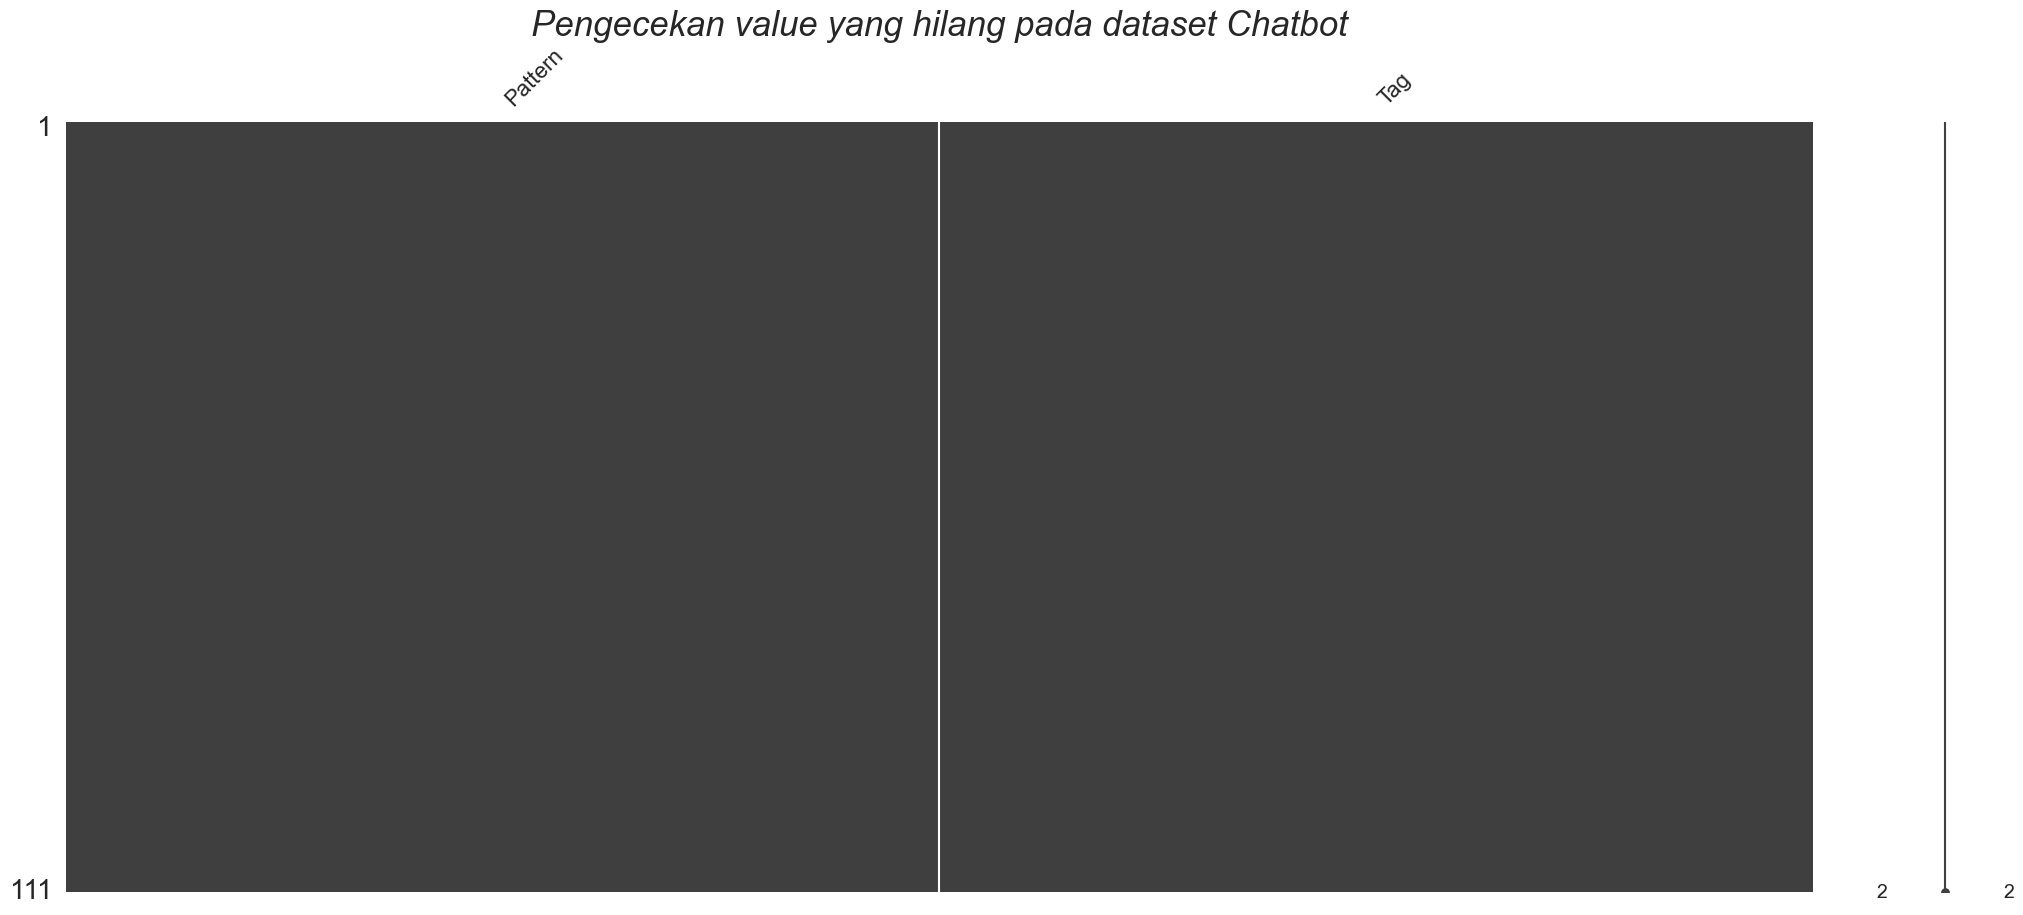

In [63]:
def gambar_plotting_value_hilang(df, ds_name="df"):
    msno.matrix(df)
    plt.title(f'Pengecekan value yang hilang pada dataset {ds_name}', fontsize=25, fontstyle='oblique')
    plt.show()
    
gambar_plotting_value_hilang(df, "Chatbot")

In [64]:
def perhitungan_distribusi_tag(x, df, title, xlabel, ylabel, width, height, order = None, rotation=False, palette='winter', hue=None):
    ncount = len(df)
    plt.figure(figsize=(width,height))
    ax = sns.countplot(x = x, palette=palette, order = order, hue=hue)
    plt.title(title, fontsize=20)
    if rotation:
        plt.xticks(rotation = 'vertical')
    plt.xlabel(xlabel, fontsize=25)
    plt.ylabel(ylabel, fontsize=25)

    ax.yaxis.set_label_position('left')
    for p in ax.patches:
        x=p.get_bbox().get_points()[:,0]
        y=p.get_bbox().get_points()[1,1]
        ax.annotate('{:.1f}%'.format(100.*y/ncount), (x.mean(), y), 
                ha='center', va='bottom') 

    plt.show()

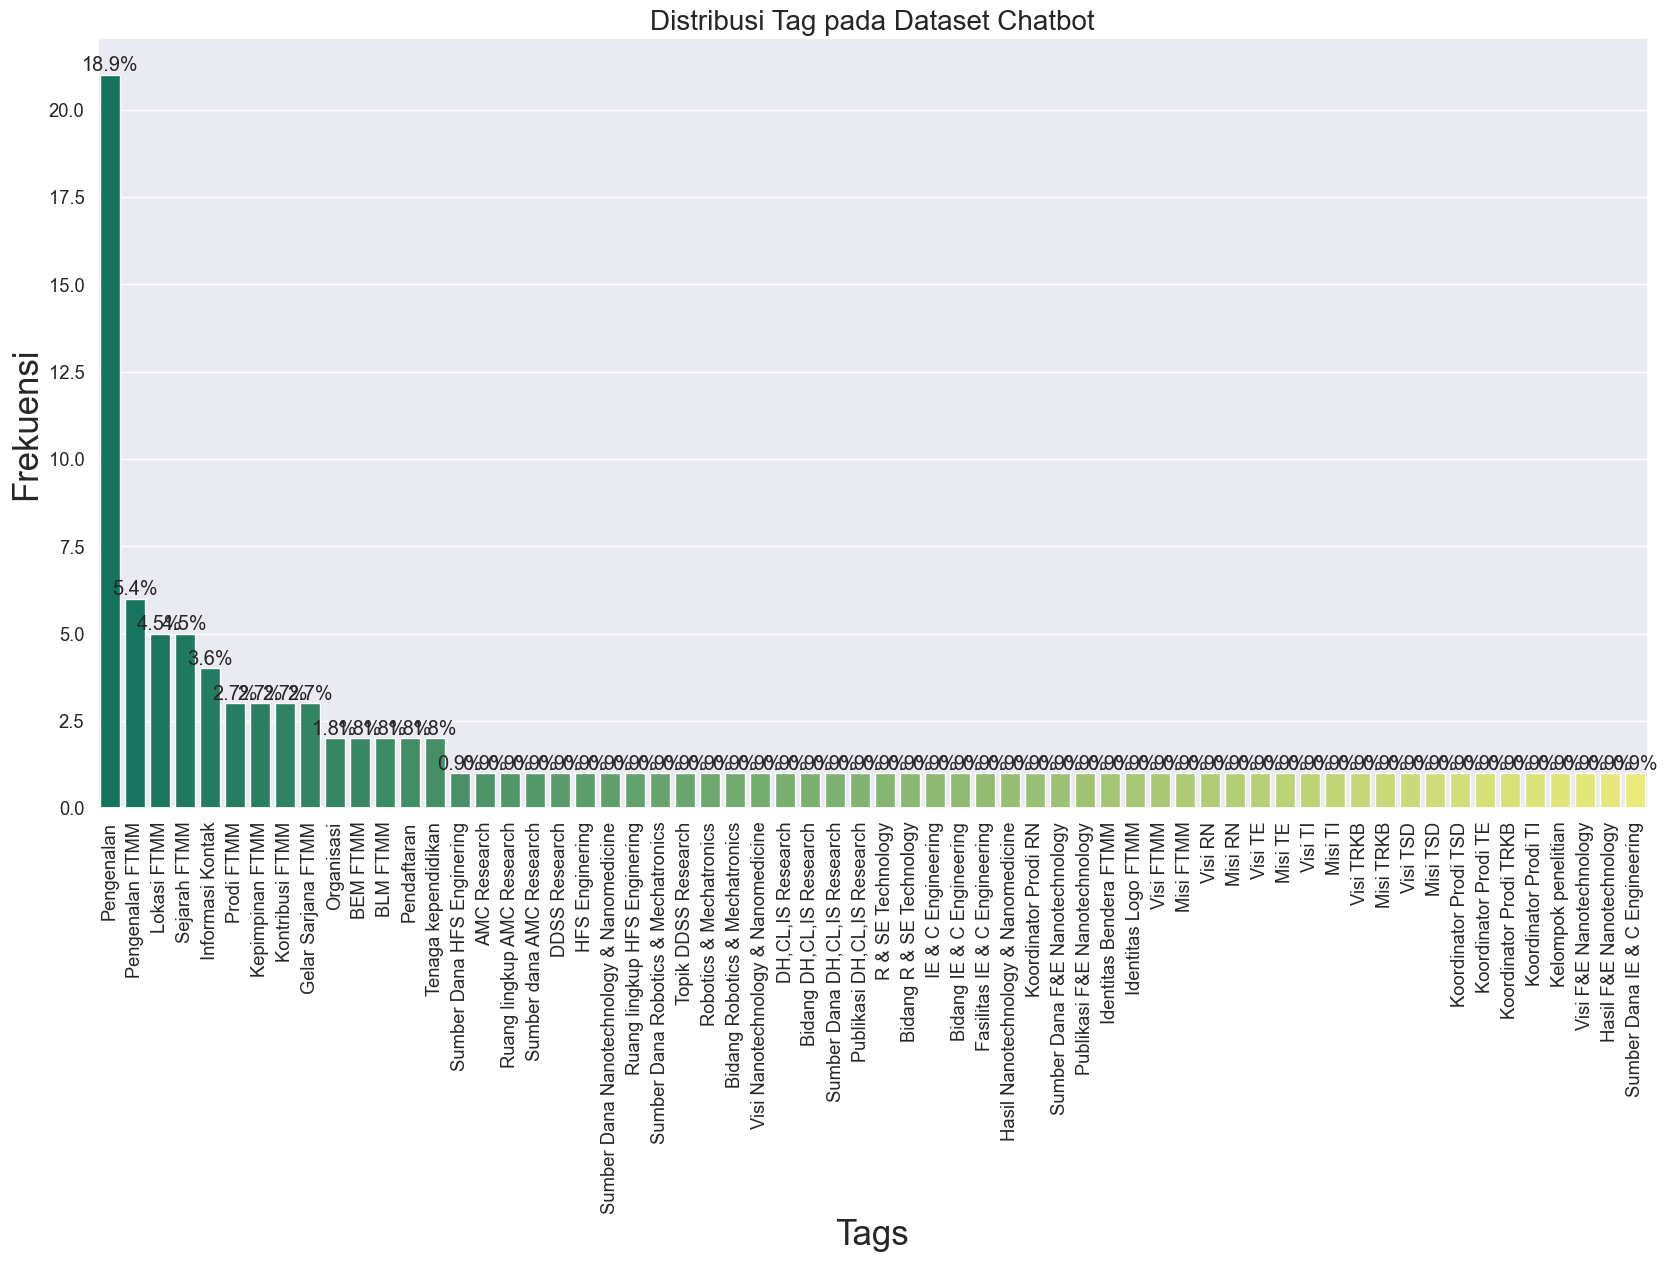

In [65]:
sns.set(font_scale = 1.2)
order = df['Tag'].value_counts().index
perhitungan_distribusi_tag(df['Tag'], df, "Distribusi Tag pada Dataset Chatbot", "Tags", "Frekuensi", 20,10, order=order,rotation=True, palette="summer")


In [66]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

factory = StemmerFactory()
stemmer = factory.create_stemmer()
ignore_words=['?', '!', ',', '.']

def preprocess_pattern(pattern):
    words = word_tokenize(pattern.lower())
    stemmed_words = [stemmer.stem(word) for word in words if word not in ignore_words]
    return " ".join(stemmed_words)  

df['Pattern'] = df['Pattern'].apply(preprocess_pattern)
df.head()

,Pattern,Tag
0,halo,Pengenalan
1,hai,Pengenalan
2,selamat pagi,Pengenalan
3,selamat siang,Pengenalan
4,selamat malam,Pengenalan


In [18]:
print(df['Pattern'].isnull().sum())

0


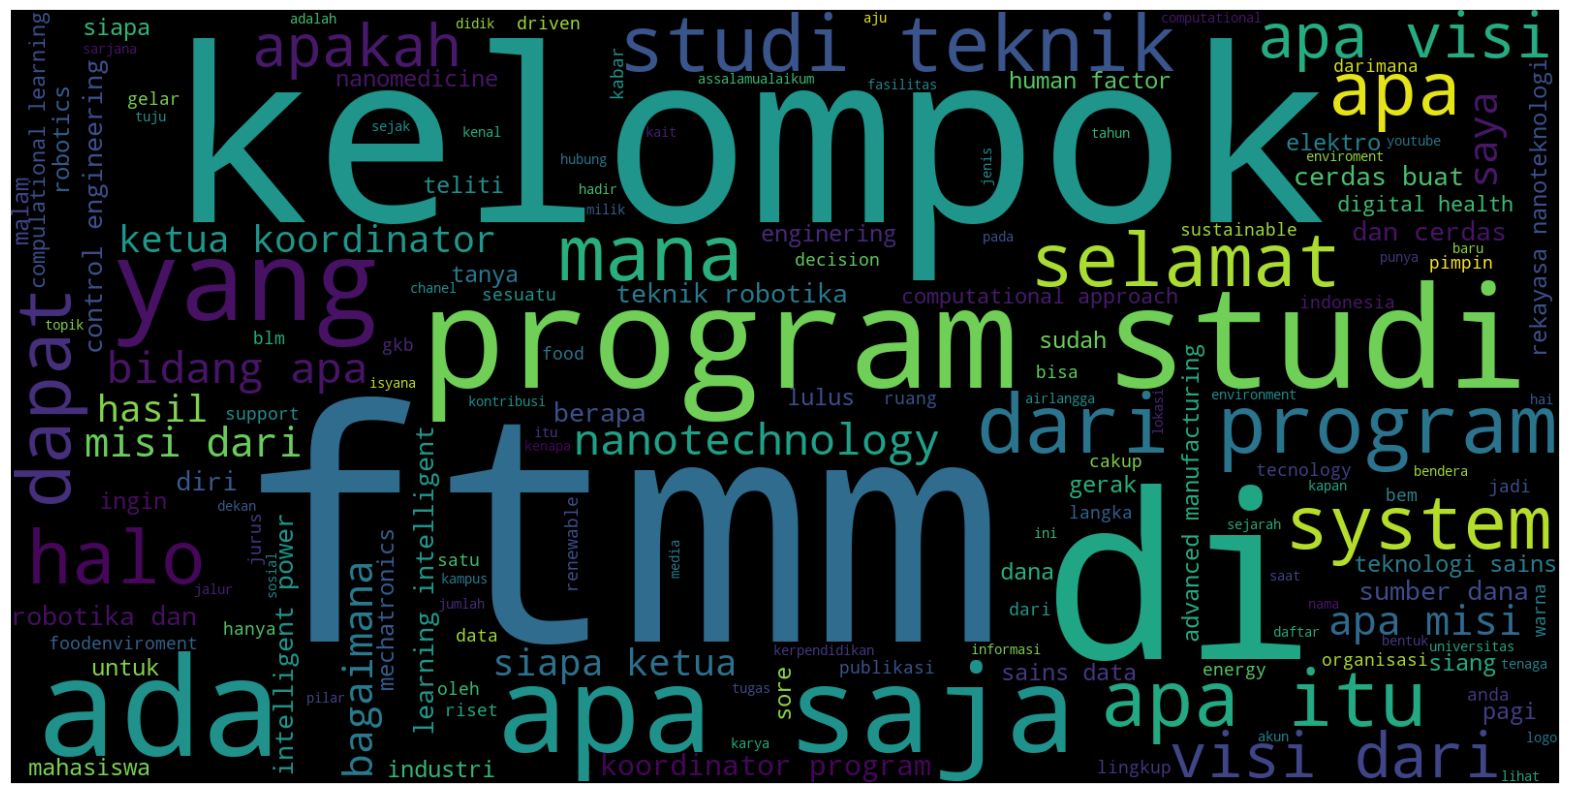

In [19]:
plt.figure(figsize=(20, 20)) 
wc = WordCloud(max_words=2000, width=1600, height=800, stopwords=STOPWORDS).generate(' '.join(df['Pattern']))
plt.imshow(wc, interpolation='bilinear')
plt.xticks([])
plt.yticks([])
plt.show()

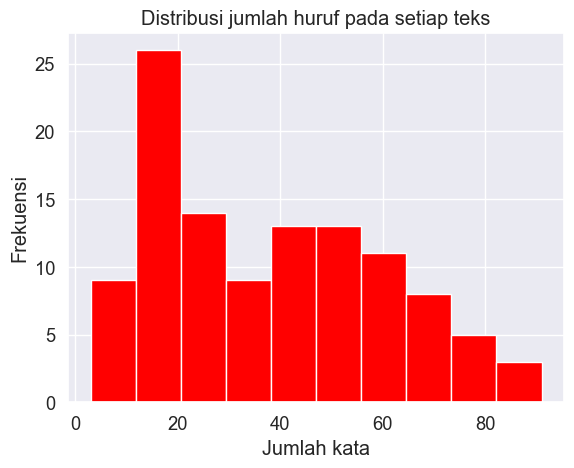

In [67]:
letters_len=df['Pattern'].str.len()
plt.hist(letters_len,color='red')
plt.title("Distribusi jumlah huruf pada setiap teks")
plt.xlabel("Jumlah kata")
plt.ylabel("Frekuensi")
plt.show()

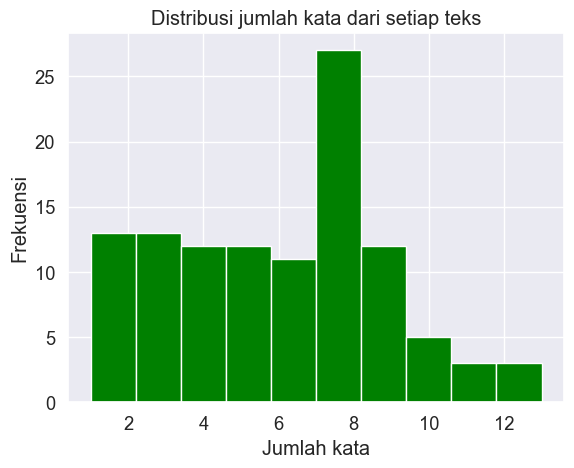

In [68]:
words_len=df['Pattern'].str.split().map(lambda x: len(x))
plt.hist(words_len,color='green')
plt.title("Distribusi jumlah kata dari setiap teks")
plt.xlabel("Jumlah kata")
plt.ylabel("Frekuensi")
plt.show()

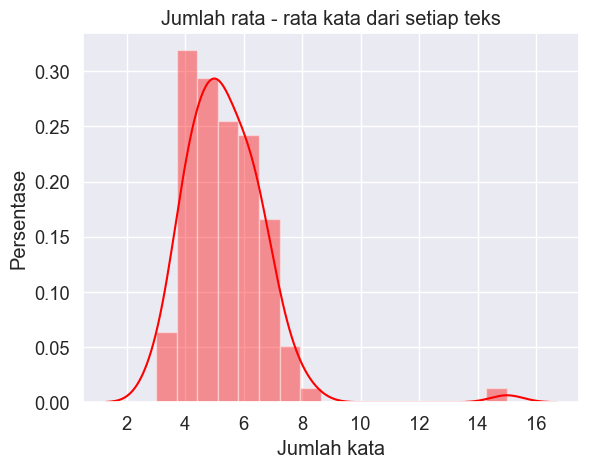

In [69]:
word=df['Pattern'].str.split().apply(lambda x : [len(i) for i in x])
word = word.map(lambda x: np.mean(x))
sns.distplot(word,color='red')
plt.title("Jumlah rata - rata kata dari setiap teks")
plt.xlabel("Jumlah kata")
plt.ylabel("Persentase")
plt.show()

In [70]:
def ambil_data_corpus(series):
    words = []
    for text in series:
        for word in text.split():
            words.append(word.strip())
    return words

corpus = ambil_data_corpus(df.Pattern)
corpus[:5]

['halo', 'hai', 'selamat', 'pagi', 'selamat']

In [71]:
print(f"Dataset mengandung {len(corpus)} kata")

Dataset mengandung 659 kata


In [73]:
from collections import Counter
counter = Counter(corpus)
most_common = counter.most_common(10)
most_common = dict(most_common)
most_common

{'apa': 51,
 'ftmm': 41,
 'dari': 26,
 'kelompok': 21,
 'di': 19,
 'program': 18,
 'studi': 18,
 'ada': 17,
 'and': 16,
 'saja': 13}

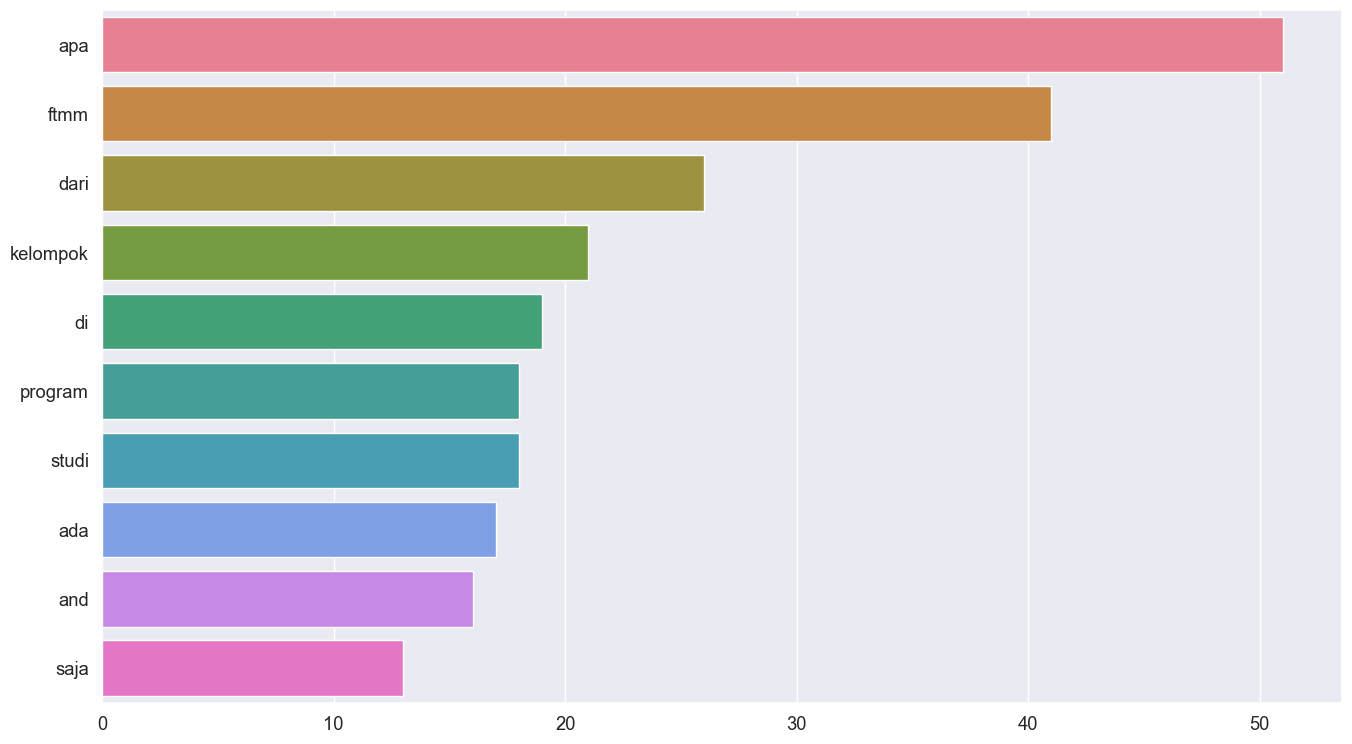

In [74]:
def get_top_text_ngrams(corpus, n,g):
    vec = CountVectorizer(ngram_range=(1, 1)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

plt.figure(figsize = (16,9))
most_common_uni = get_top_text_ngrams(df.Pattern,10,1)
most_common_uni = dict(most_common_uni)
colors = sns.color_palette("husl", 10)
sns.barplot(x=list(most_common_uni.values()),y=list(most_common_uni.keys()),palette=colors);

In [43]:
df2

,Pattern,Tag,labels
0,Halo,Pengenalan,0
1,Hai,Pengenalan,0
2,selamat pagi,Pengenalan,0
3,selamat siang,Pengenalan,0
4,selamat malam,Pengenalan,0
...,...,...,...
106,Kelompok riset renewable and Sustainable Energ...,Bidang R & SE Technology,57
107,Apa itu Intelligent Power and Control Engineer...,IE & C Engineering,58
108,Kelompok Intelligent Power and Control Enginee...,Bidang IE & C Engineering,59
109,Apa saja fasilitas yang ada pada kelompok Inte...,Fasilitas IE & C Engineering,60


In [28]:
labels = df2['Tag'].unique().tolist()
labels = [s.strip() for s in labels]
labels

['Pengenalan',
 'Pengenalan FTMM',
 'Lokasi FTMM',
 'Informasi Kontak',
 'Sejarah FTMM',
 'Prodi FTMM',
 'Kepimpinan FTMM',
 'Kontribusi FTMM',
 'Gelar Sarjana FTMM',
 'Identitas Bendera FTMM',
 'Identitas Logo FTMM',
 'Visi FTMM',
 'Misi FTMM',
 'Visi RN',
 'Misi RN',
 'Visi TE',
 'Misi TE',
 'Visi TI',
 'Misi TI',
 'Visi TRKB',
 'Misi TRKB',
 'Visi TSD',
 'Misi TSD',
 'Pendaftaran',
 'Organisasi',
 'BEM FTMM',
 'BLM FTMM',
 'Koordinator Prodi TSD',
 'Koordinator Prodi TE',
 'Koordinator Prodi TRKB',
 'Koordinator Prodi TI',
 'Koordinator Prodi RN',
 'Tenaga kependidikan',
 'Kelompok penelitian',
 'Visi F&E Nanotechnology',
 'Hasil F&E Nanotechnology',
 'Publikasi F&E Nanotechnology',
 'Sumber Dana F&E Nanotechnology',
 'Visi Nanotechnology & Nanomedicine',
 'Hasil Nanotechnology & Nanomedicine',
 'Sumber Dana Nanotechnology & Nanomedicine',
 'HFS Enginering',
 'Ruang lingkup HFS Enginering',
 'Sumber Dana HFS Enginering',
 'AMC Research',
 'Ruang lingkup AMC Research',
 'Sumber dana 

In [29]:
num_labels = len(labels)
id2label = {id:label for id, label in enumerate(labels)}
label2id = {label:id for id, label in enumerate(labels)}
id2label

{0: 'Pengenalan',
 1: 'Pengenalan FTMM',
 2: 'Lokasi FTMM',
 3: 'Informasi Kontak',
 4: 'Sejarah FTMM',
 5: 'Prodi FTMM',
 6: 'Kepimpinan FTMM',
 7: 'Kontribusi FTMM',
 8: 'Gelar Sarjana FTMM',
 9: 'Identitas Bendera FTMM',
 10: 'Identitas Logo FTMM',
 11: 'Visi FTMM',
 12: 'Misi FTMM',
 13: 'Visi RN',
 14: 'Misi RN',
 15: 'Visi TE',
 16: 'Misi TE',
 17: 'Visi TI',
 18: 'Misi TI',
 19: 'Visi TRKB',
 20: 'Misi TRKB',
 21: 'Visi TSD',
 22: 'Misi TSD',
 23: 'Pendaftaran',
 24: 'Organisasi',
 25: 'BEM FTMM',
 26: 'BLM FTMM',
 27: 'Koordinator Prodi TSD',
 28: 'Koordinator Prodi TE',
 29: 'Koordinator Prodi TRKB',
 30: 'Koordinator Prodi TI',
 31: 'Koordinator Prodi RN',
 32: 'Tenaga kependidikan',
 33: 'Kelompok penelitian',
 34: 'Visi F&E Nanotechnology',
 35: 'Hasil F&E Nanotechnology',
 36: 'Publikasi F&E Nanotechnology',
 37: 'Sumber Dana F&E Nanotechnology',
 38: 'Visi Nanotechnology & Nanomedicine',
 39: 'Hasil Nanotechnology & Nanomedicine',
 40: 'Sumber Dana Nanotechnology & Nanome

In [30]:
label2id

{'Pengenalan': 0,
 'Pengenalan FTMM': 1,
 'Lokasi FTMM': 2,
 'Informasi Kontak': 3,
 'Sejarah FTMM': 4,
 'Prodi FTMM': 5,
 'Kepimpinan FTMM': 6,
 'Kontribusi FTMM': 7,
 'Gelar Sarjana FTMM': 8,
 'Identitas Bendera FTMM': 9,
 'Identitas Logo FTMM': 10,
 'Visi FTMM': 11,
 'Misi FTMM': 12,
 'Visi RN': 13,
 'Misi RN': 14,
 'Visi TE': 15,
 'Misi TE': 16,
 'Visi TI': 17,
 'Misi TI': 18,
 'Visi TRKB': 19,
 'Misi TRKB': 20,
 'Visi TSD': 21,
 'Misi TSD': 22,
 'Pendaftaran': 23,
 'Organisasi': 24,
 'BEM FTMM': 25,
 'BLM FTMM': 26,
 'Koordinator Prodi TSD': 27,
 'Koordinator Prodi TE': 28,
 'Koordinator Prodi TRKB': 29,
 'Koordinator Prodi TI': 30,
 'Koordinator Prodi RN': 31,
 'Tenaga kependidikan': 32,
 'Kelompok penelitian': 33,
 'Visi F&E Nanotechnology': 34,
 'Hasil F&E Nanotechnology': 35,
 'Publikasi F&E Nanotechnology': 36,
 'Sumber Dana F&E Nanotechnology': 37,
 'Visi Nanotechnology & Nanomedicine': 38,
 'Hasil Nanotechnology & Nanomedicine': 39,
 'Sumber Dana Nanotechnology & Nanomedici

In [31]:
df2['labels'] = df2['Tag'].map(lambda x: label2id[x.strip()])
df2.head()

,Pattern,Tag,labels
0,Halo,Pengenalan,0
1,Hai,Pengenalan,0
2,selamat pagi,Pengenalan,0
3,selamat siang,Pengenalan,0
4,selamat malam,Pengenalan,0


In [32]:
X = list(df2['Pattern'])
X[:5]

['Halo', 'Hai', 'selamat pagi', 'selamat siang', 'selamat malam']

In [33]:
y = list(df2['labels'])
y[:5]

[0, 0, 0, 0, 0]

In [34]:
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state = 123)

In [35]:
model_name = "bert-base-uncased"
max_len = 256

tokenizer = BertTokenizer.from_pretrained(model_name, 
                                          max_length=max_len)

model = BertForSequenceClassification.from_pretrained(model_name, 
                                                      num_labels=num_labels, 
                                                      id2label=id2label, 
                                                      label2id = label2id)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [36]:
train_encoding = tokenizer(X_train, truncation=True, padding=True)
test_encoding = tokenizer(X_test, truncation=True, padding=True)
full_data = tokenizer(X, truncation=True, padding=True)

In [37]:
class DataLoader(Dataset):
    
    def __init__(self, encodings, labels):
        
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
               
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):

        return len(self.labels)

train_dataloader = DataLoader(train_encoding, y_train)
test_dataloader = DataLoader(test_encoding, y_test)
fullDataLoader = DataLoader(full_data, y_test)

In [75]:
def perhitungan_nilai_metrik(pred):

    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    
    return {
        'Accuracy': acc,
        'F1': f1,
        'Precision': precision,
        'Recall': recall
    }

In [39]:
training_args = TrainingArguments(
    output_dir='./output', 
    do_train=True,
    do_eval=True,
    num_train_epochs=100,              
    per_device_train_batch_size=32,  
    per_device_eval_batch_size=16,
    warmup_steps=100,                
    weight_decay=0.05,
    logging_strategy='steps',
    logging_dir='./multi-class-logs',            
    logging_steps=50,
    evaluation_strategy="steps",
    eval_steps=50,
    save_strategy="steps", 
    load_best_model_at_end=True
)

In [40]:
trainer = Trainer(
    model=model,
    args=training_args,                 
    train_dataset=train_dataloader,         
    eval_dataset=test_dataloader,            
    perhitungan_nilai_metrik= perhitungan_nilai_metrik
)
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
50,3.830600,3.561979,0.250000,0.039286,0.030983,0.083333
100,2.719400,3.084146,0.285714,0.077586,0.073892,0.103448
150,1.443000,2.877054,0.357143,0.133333,0.123333,0.166667
200,0.718500,2.989318,0.357143,0.144444,0.140000,0.166667
250,0.435800,2.971075,0.357143,0.144444,0.140000,0.166667
300,0.316400,2.998546,0.357143,0.144444,0.140000,0.166667


TrainOutput(global_step=300, training_loss=1.5772696463267009, metrics={'train_runtime': 6577.2735, 'train_samples_per_second': 1.262, 'train_steps_per_second': 0.046, 'total_flos': 123759664734000.0, 'train_loss': 1.5772696463267009, 'epoch': 100.0})

In [41]:
q=[trainer.evaluate(eval_dataset=df2) for df2 in [train_dataloader, test_dataloader]]

pd.DataFrame(q, index=["train","test"]).iloc[:,:5]

,eval_loss,eval_Accuracy,eval_F1,eval_Precision,eval_Recall
train,0.236033,1.000000,1.000000,1.00,1.000000
test,2.998546,0.357143,0.144444,0.14,0.166667


In [46]:
model_path = "chatbot"
trainer.save_model(model_path)
tokenizer.save_pretrained(model_path)

('chatbot\\tokenizer_config.json',
 'chatbot\\special_tokens_map.json',
 'chatbot\\vocab.txt',
 'chatbot\\added_tokens.json')

In [79]:
model_path = r'C:\Users\lenovo\Documents\Coding Jupyter\chatbot'

model = BertForSequenceClassification.from_pretrained(model_path)
tokenizer= BertTokenizerFast.from_pretrained(model_path)
chatbot= pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

In [51]:
chatbot("TRKB itu bidang mana ya?")

[{'label': 'Sejarah FTMM', 'score': 0.633514940738678}]

In [77]:
def chat(chatbot):
    
    print("Chatbot: Halo! Silakan masukkan pertanyaan Anda seputar FTMM! ")
    print("Ketik 'keluar' untuk keluar dari percakapan\n\n")
    
    text = input("User: ").strip().lower()
    
    while(text != 'keluar'):

        score = chatbot(text)[0]['score']
        
        if score < 0.5:
            print("Chatbot: Maaf saya tidak bisa menjawab pertanyaan tersebut\n\n")
            text = input("User: ").strip().lower()
            continue
        
        label = label2id[chatbot(text)[0]['label']]
        response = random.choice(intents['intents'][label]['responses'])
        
        print(f"Chatbot: {response}\n\n")
            
        text = input("User: ").strip().lower()

In [78]:
chat(chatbot)

Chatbot: Halo! Silakan masukkan pertanyaan Anda seputar FTMM! 
Ketik 'keluar' untuk keluar dari percakapan




User:  keluar
